Steps:
* Using TensorFlow Datasets to download and explore data
* Creating a preprocessing function for our data 
* Batching and preparing datasets for modelling (making them run fast)
* Setting up **mixed precision training** (for faster model training)
* Building and training a feature extraction model
* Fine-tuning the feature extraction model to beat the DeepFood paper
* Evaluating results on TensorBoard
* Evaluating results by making and plotting predictions


# Checking the GPU for Mixed Precision Training

Since we are dealing with such a huge training set, we can certainly benefit from speeding up the process by using Mixed Precision Training. Unfortunately, this requires having access to a GPU of Compute Capability `7.0` or higher and the only GPU that Colab gives access to is the Tesla T4 (that meets the requirement).  

In [2]:
!nvidia-smi -L

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



# Data and Prep

We bring in the data for Food101 using TensorFlow datasets: the benefit with this is that we can skip some preprocessing steps since the data is **already in tensor format**.

Similarly we define some helper functions for later.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime

def create_tensorboard_callback(experiment, root_dir="food101models"):
  """Creates a TensorBoard callback instance to store log files"""
  log_dir = root_dir + "/" + experiment + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

def plot_loss_curves(history):
  """Plots the loss and accuracy curves for a given History object on seperate graphs"""
  # Get the information
  acc = history.history["accuracy"]
  loss = history.history["loss"]
  val_acc = history.history["val_accuracy"]
  val_loss = history.history["val_loss"]

  epochs = range(len(history.history["loss"]))

  # Plot the accuracy curves
  plt.figure()
  plt.plot(epochs, acc, label="Training Accuracy")
  plt.plot(epochs, val_acc, label="Validation Accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

  # Plot Loss curves
  plt.figure()
  plt.plot(epochs, loss, label="Training Loss")
  plt.plot(epochs, val_loss, label="Validation Loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()


def compare_historys(original_history, new_history, initial_epochs=3):
    """Compares two TensorFlow model History objects. Designed for Fine-tuning experiments."""
    
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

In [ ]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

# Check if Food101 is inside the list of datasets
"food101" in tfds.list_builders()

True

In [ ]:
# Now to load in the data (takes a while)
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True, # Data returned in tuple (data, label)
                                             with_info=True)

# Exploring the Data

Some standard procedures and things to find when exploring a new dataset:
* Find Input shapes
* Find class names
* Convert images to tensors (already done)
* The datatype of our input data
* What the labels look like (are they one-hot-encoded or label-encoded)

In [ ]:
# Get features of Food101
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [ ]:
# Get the class names and look at the first few
class_names = ds_info.features["label"].names
class_names[:12]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad']

In [ ]:
# Take one sample of the train data
train_sample = train_data.take(1) # Samples are in format (tensor, label)
train_sample

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [ ]:
# Output info about our training sample
for image, label in train_sample:
  print(f"""
  Image Shape: {image.shape},
  Image datatype: {image.dtype},
  Target class from Food101 (tensor form): {label},
  Class name (string form): {class_names[label.numpy()]}
  """)


  Image Shape: (512, 512, 3),
  Image datatype: <dtype: 'uint8'>,
  Target class from Food101 (tensor form): 72,
  Class name (string form): pancakes
  


So we can see that the label in this dataset is *not* one-hot-encoded. This was important to find out since it determines what Loss Function we should use.

In [ ]:
# Peek at the image tensor
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 42,  40,  51],
        [ 41,  39,  50],
        [ 40,  38,  49],
        ...,
        [ 50,  23,   6],
        [ 51,  24,   7],
        [ 51,  24,   7]],

       [[ 41,  39,  50],
        [ 41,  39,  50],
        [ 41,  39,  50],
        ...,
        [ 47,  20,   3],
        [ 48,  21,   4],
        [ 49,  22,   5]],

       [[ 40,  38,  49],
        [ 41,  39,  50],
        [ 42,  40,  51],
        ...,
        [ 47,  20,   3],
        [ 48,  21,   4],
        [ 48,  21,   4]],

       ...,

       [[188, 180, 191],
        [188, 180, 191],
        [189, 181, 192],
        ...,
        [179, 178, 186],
        [177, 176, 184],
        [175, 174, 182]],

       [[185, 177, 188],
        [186, 178, 189],
        [187, 179, 190],
        ...,
        [178, 177, 185],
        [176, 175, 183],
        [175, 174, 182]],

       [[179, 171, 182],
        [181, 173, 184],
        [183, 175, 186],
        ...,
        [177, 176, 18

In [ ]:
# Find the range of the pixel values in the image tensor
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

Okay so the pixel values are in the range we expect. 

Note that if we take a look at multiple images (running `take()` multiple times), we see that their shapes are *not* all the same which means we'd have to resize them. 

Their datatypes are integers which is a problem since we need to cast floats for the image tensor to optimize performance.

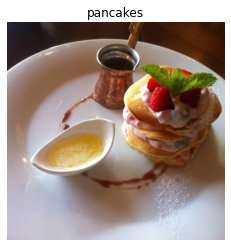

In [ ]:
# Plot an image tensor and check if the given label is correct
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

# Preprocessing the Data

We have already extracted the data and split it thanks to TensorFlow Datasets. Now to work on preprocessing it before passing it to our Network.

Some facts:
* The values are all `uint8`- we'd like to cast as `float16` or `float32` since Neural Networks perform better off those
* The values are *not* scaled- we may have to normalize the values depending on which architecture we use
* The image tensors are all of different shapes- we need to resize them to a common shape

Let's write a preprocessing function to address these. We won't normalize the pixel values however, since we will use an `EfficientNetBX` model which already has rescaling built in.

In [ ]:
# Make a preprocessing function
def preprocess_img(image, label, img_shape=224):
  """Converts image datatype from `uint8` to `float32` and reshapes image tensor to [img_shape, img_shape, color_channels]"""
  image = tf.image.resize(image, [img_shape, img_shape])
  # Return a tuple of image and label
  return tf.cast(image, tf.float32), label 

In [ ]:
# Test out the function on the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}..., \nShape: {image.shape}, \nDatatype:{image.dtype}")
print()
print(f"Image after preprocessing:\n {preprocessed_img[:2]}..., \nShape: {preprocessed_img.shape}, \nDatatype:{preprocessed_img.dtype}")

Image before preprocessing:
 [[[42 40 51]
  [41 39 50]
  [40 38 49]
  ...
  [50 23  6]
  [51 24  7]
  [51 24  7]]

 [[41 39 50]
  [41 39 50]
  [41 39 50]
  ...
  [47 20  3]
  [48 21  4]
  [49 22  5]]]..., 
Shape: (512, 512, 3), 
Datatype:<dtype: 'uint8'>

Image after preprocessing:
 [[[41.127552  39.127552  50.127552 ]
  [40.642857  38.642857  49.642857 ]
  [40.285713  38.285713  49.285713 ]
  ...
  [48.92855   21.928549   4.500022 ]
  [47.7398    20.739801   3.7398005]
  [49.301044  22.301043   5.3010426]]

 [[40.642857  38.642857  49.642857 ]
  [42.9949    40.9949    51.9949   ]
  [41.85714   39.85714   50.85714  ]
  ...
  [49.127533  22.127531   4.699003 ]
  [47.862247  20.862246   3.8622463]
  [48.928574  21.928572   4.9285717]]]..., 
Shape: (224, 224, 3), 
Datatype:<dtype: 'float32'>


Beautiful. Now the images have the same universal shape and the pixel values are cast as floats. 

Note that we did not normalize values since we'll use `EfficientNetBX`- if we wanted to do this inside the function, it would be as simple as `image = image / 255.`

## Batching and preparing our Datasets

Now we made a function to preprocess *one* image; we want this function to be applied to *all* images so all our data is ready for preprocessing.

TensorFlow has great documentation for **data input pipelines**: https://www.tensorflow.org/guide/data 

We will utilise some of the techniques mentioned in the documentation. We will
* Apply the function to all the images
* Turn our data into **batches**

In [ ]:
# Map preprocessing function to training (and parallelize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle train_data and turn it into Batches; also, prefetch it (runs faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In this step, we used `map` to map the function to all the training instances. It is important to note that the function we wrote also included and returned the `label`. This was done because the `train_data` we got from `tfds` returned both the image tensors **and** the labels. So we don't lose on any formatting here.

The second argument which specifies `AUTOTUNE` basically tells TensorFlow to have Colab use **all** the computational power it has.

In the second line of code, we `shuffle` the training data and set the number of samples we want to shuffle: ideally we'd set it to `len(train_data)` but with so many samples, we need to cut it small. After that we `batch` to form the mini-batches and call `prefetch` which is something that speeds the process up by having our kernel preprocess already loaded-in images on our CPU while the others are being operated on our GPU.

In [ ]:
# Check the two sets
train_data, test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

Perfect!

The images are of the proper size, and have the appropriate data types. Loading these two sets in is very fast, since we defined the parallelization strategy.

A summary of what we did:
* Map a preprocessing function to the training set
* Shuffled a number of elements across the training set 
* Enabled Prefetching and set up parallelization (multithreaded loading across all available CPUs)

# Modelling

Before we start creating our model, we need to instantiate some Callbacks.

This is because we have so many training instances, hence training can take a long time and we want to be able to do things like log performance on TensorBoard so we can view it later, etc.

We'll make use of
* the TensorBoard callback to visualize training results later if we want (already functionalized)
* `ModelCheckpoint` to save our model's performance after feature extraction

In [ ]:
# Create the Checkpoint callback
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_loss",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

## Setup Mixed Precision Training

Again, this speeds up processes by using lower-bit precision for floats. It only works if we have enough Compute Capability on our GPU; if we want to use Colab, Tesla T4 is the only one that supports Mixed Precision Training that is offered by Google.

What's the logic for this speeding up by a possible **factor of 3**?

This just has the GPU (which can only fit a certain number of bits in it) convert `float32` to `float16` when it can so it can carry out even more processes at once.

In [ ]:
# Turn on Mixed Precision training (only works with a compatible GPU)
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16") 

# Build Feature Extraction Model

When setting up a model with Mixed Precision Training, we have to make one more change to our workflow: we specify the `dtype` of the Output Layer to be `float32` to preserve **numeric stability** (look at the docs mentioned above).

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model which we freeze
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
# x = preprocessing.Rescaling(1./255)(inputs) <- use this for non-EfficientNet backbones
x = base_model(inputs, training=False) # Keep in Inference Mode
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_output")(x) # Specify dtype for Mixed Precision numeric stability

model = tf.keras.Model(inputs, outputs)

# Compile the model- classes are label encoded so we can't use Categorical Crossentropy
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

16711680/16705208 [==============================] - 0s 0us/step


In [ ]:
# Check the structure
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


So how do you check for Mixed Precision being used?

You can loop through each layer and check *which* `dtype_policy` is being used. We don't have it enabled right now (since we don't have access to a T4) but the policy for each layer would be the same we specified earlier: `mixed_float16`.

In [ ]:
# Check the dtype_policy for each layer
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "float32">
global_average_pooling2d True float32 <Policy "float32">
dense True float32 <Policy "float32">
softmax_float32 True float32 <Policy "float32">


If you check the policy for each and every layer in the `EfficientNetB0` backbone, you will find the same mixed precision `dtype_policy`  for **all** the underlying layers. 

## Fitting the Feature Extraction Model

In [ ]:
# Fit the feature extraction model for 3 epochs 
history_feature_extraction = model.fit(train_data,
                                       epochs=3,
                                       validation_data=test_data,
                                       validation_steps=int(0.15*len(test_data)),
                                       callbacks=[create_tensorboard_callback(experiment="feature_extraction_model"),
                                                  model_checkpoint])

In [ ]:
# Check the Loss curves
plot_loss_curves(history_feature_extraction)

If you actually enabled Mixed Precision Training, you'd find that the time it takes to complete one epoch is just **three minutes**. And this is with **75000 training images** in total; that is FAST.

Our score to beat is around 76% which comes from the DeepFood paper.

In [ ]:
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

## Saving the Model

When fine-tuning our model, it will be helpful to have saved the Feature Extraction model so we can return/revert to it if we want to try different techniques.

Since this is a huge model, let's save it to Google Drive instead of Colab.

In [ ]:
# Save model to Drive after mounting
save_dir = "drive/MyDrive/models/food101/feature_extraction"
os.makedirs(save_dir) # Make this directory if it doesn't already exist

# Save model
model.save(save_dir)

In [ ]:
# Load the model we just saved
loaded_model = tf.keras.models.load_model(save_dir)

# Get evaluation metrics for loaded model to compare to the variable saved before
results_loaded = loaded_model.evaluate(test_data)

results_loaded, results_feature_extract_model # Should be very close

# Fine-tuning

Now to try and beat the score on the DeepFood paper. 

In [ ]:
# Download the saved model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip

In [ ]:
# Unzip the SavedModel downloaded from Google Stroage
!mkdir downloaded_gs_model # create new dir to store downloaded feature extraction model
!unzip 07_efficientnetb0_feature_extract_model_mixed_precision.zip -d downloaded_gs_model

In [ ]:
# Load and evaluate the downloaded model
downloaded_model = tf.keras.models.load_model("/content/downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision")
results_downloaded = downloaded_model.evaluate(test_data)
results_downloaded

In [ ]:
# What does the downloaded model look like?
downloaded_model.summary()

We will make use of `EarlyStopping` to reduce the chances of Overfitting as best we can- specifically we will stop training if the Validation Loss does not improve for 3 epochs.  

`ReduceLROnPlateau` will also be helpful: it will automatically reduce the Learning Rate as the Loss approches the minimum value (we don't want it to continously make equally big jumps). 

We will also use the `ModelCheckpoint` callback to save the best model during fine-tuning so we can run experiments later if we desire.

In [ ]:
# Setup EarlyStopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)

# Setup ReduceLROnPlateau
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2,
                                                 patience=2,
                                                 min_lr=1e-7,
                                                 verbose=1)
# Create another ModelCheckpoint
checkpoint_path = "fine_tune_checkpoints/"
finetune_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_best_only=True,
                                                         monitor="val_loss")

In this Fine-tuning round, we will unfreeze **all** the layers in the base model. We do this because we have a **lot** of data and we can afford to do this step: if we had much less data, we would risk Overfitting if we unfroze too many layers in the pretrained model.

A final note on Fine-tuning: a good rule of thumb is to set the initial Learning Rate of our Optimizer around `10x` lower than the value used for training the Feature Extractor: the default for `Adam` is `0.001` so we shall use `0.0001`.

In [ ]:
# Unfreeze all of the model layers (including the base model)
for layer in downloaded_model.layers:
  layer.trainable = True
  print(layer.name, layer.trainable)

# Find the number of trainable layers in the base model as a final check
count = 0
for layer in downloaded_model.layers[1].layers:
  count += int(layer.trainable)
print(f"Number of trainable layers in EfficientNetB0: {count}")

In [ ]:
# Compile the model now
downloaded_model.compile(loss="sparse_categorical_crossentropy",
                         optimizers=tf.keras.optimizers.Adam(learning_rate=0.0001),
                         metrics=["accuracy"])

In [ ]:
# Fit for 100 epochs since we don't care for Overfitting
history_fine_tune = downloaded_model.fit(train_data,
                                         epochs=100,
                                         steps_per_epoch=len(train_data),
                                         validation_data=test_data,
                                         validation_steps=int(0.15 * len(test_data)),
                                         callbacks=[create_tensorboard_callback(experiment="finetuned_model"),
                                                    finetune_checkpoint,
                                                    early_stopping,
                                                    reduce_lr],
                                         verbose=0)

In [ ]:
# Save model to Drive 
save_dir = "drive/MyDrive/models/food101/finetune"
os.makedirs(save_dir) # Make this directory if it doesn't already exist

# Save model
downloaded_model.save(save_dir)

In [ ]:
# Download it 
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip

# Unzip fine-tuned model
!mkdir downloaded_fine_tuned_gs_model # create separate directory for fine-tuned model downloaded from Google Storage
!unzip /content/07_efficientnetb0_fine_tuned_101_classes_mixed_precision -d downloaded_fine_tuned_gs_model

In [ ]:
# Load in fine-tuned model from Google Storage and evaluate
final_model = tf.keras.models.load_model("/content/downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_mixed_precision")

# Evaluate model
results_finetuned = final_model.evaluate(test_data)
results_finetuned

It seems that our model beat the results of the DeepFood paper (77.4% top-1 accuracy).

In [ ]:
# Get the summary
final_model.summary()

# Evaluating

Now that we've formed a model to beat the DeepFood paper, let's visualize some predictions.

Some things to try out:
* Plot Loss curves
* A Classification Report to see the model performance on a class-by-class basis
* A graph to display the F1-scores of each class
* Plotting a random image and having the model make a prediction on it, then visualizing the full picture
* Finding the "most wrong" model predictions


In [ ]:
# Plot Loss curves across finetuning
compare_historys(history_feature_extraction, history_fine_tune)

In [ ]:
# Make predictions with the model
pred_probs = final_model.predict(test_data, verbose=1)

# Check the structure of the predictions predictions
print(f"Number of predictions: {len(pred_probs)}")
print(f"Shape of predictions: {pred_probs.shape}")
print(f"Number of prediction probabilities for sample 0: {len(pred_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {pred_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {pred_probs[0].argmax()}")

In [ ]:
# Get the class predictions of each label
pred_classes = pred_probs.argmax(axis=1)
pred_classes[:10]

In [ ]:
# Get the labels now that we have the predicted classes
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())
y_labels[:10]

In [ ]:
# Make a classification report
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

In [ ]:
# Now to construct a plot of the F1-scores for each class
cr_dict = classification_report(y_labels, pred_classes, output_dict=True)

# Prepare dictionary for holding F1-scores
f1_scores = {}
for k,v in cr_dict.items():
  if k == "accuracy": # Reached the end of the F1-scores
    break
  else:
    f1_scores[class_names[int(k)]] = v["f1-score"]

# Make a DataFrame
import pandas as pd
f1_df = pd.DataFrame({
    "class_name": list(f1_scores.keys()),
    "f1-score": list(f1_scores.values())
}).sort_values("f1-score", ascending=False)

f1_df

In [ ]:
# Make a Horizontal Bar chart with it
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,25))
scores = ax.barh(range(len(f1_df)), f1_df["f1-score"].values)
ax.set_yticks(range(len(f1_df)))
ax.set_yticklabels(list(f1_df["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-scores for each Food101 class")
ax.invert_yaxis()

In [ ]:
# Get a random image
sample = train_data.take(1)

plt.figure(figsize=(18,10))

# Display predictions for three samples
for i in range(3):
  for image, label in sample:
    # Plot the image
    plt.imshow(image / 255.)
    # Grab the prediction for the tensor
    pred = final_model.predict(tf.expand_dims(image, axis=1))
    predicted_class = class_names[pred.argmax()]
    # Display the title
    color = "red"
    if predicted_class == label:
      color = "green"
    plt.title(f"Predicted: {predicted_class}, Prob: {pred.max():.2f}\n
    Actual: {label}", c=color)
    plt.axis(False);

# FIN